# Morfologia

### Zmienne i wymagane biblioteki

In [75]:
import matplotlib.pyplot as plt # Wyświetlanie obrazów
import cv2 # Operacje na obrazach
import numpy as np # Operacje na macierzach
from os import listdir # Wyświetlanie zawartości folderu
from tqdm.notebook import tqdm # Pasek postępu
from skimage.filters import frangi, hessian # Filtrowanie po detekcji
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Macierz pomyłek
import math # Operacje matematyczne

%matplotlib inline

# Folder z obrazami
IMG_DIR = 'images'
# Lista plików w powyższym folderze
image_names = [f"{IMG_DIR}/{img}" for img in listdir(IMG_DIR)]

### Funkcje pomocnicze

In [2]:
def invert_colors(img):
    '''
    Odwróć kolory w obrazie.
    :param img: - obraz, w którym należy odwrócić kolory
    :return new_image: - obraz z odwróconymi kolorami
    '''
    new_image = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for x, row in enumerate(img):
        for y, _ in enumerate(row):
            new_image[x][y] = abs(255 - img[x][y])
    return new_image

In [3]:
def remove_background(img, mask):
    '''
    Usuwanie tła za pomocą maski, czyli usuwanie koloru pikseli zaznaczonych w masce
    na inny kolor niż czarny.
    :param img: - obraz wejściowy
    :param mask: - maska do usuwania tła
    :return new_image: - obraz z nałożoną maską
    '''
    new_image = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for x, row in enumerate(img):
        for y, _ in enumerate(row):
            new_image[x][y] = img[x][y] if mask[x][y] == 0 else 0
    return new_image

### Wstępne przetwarzanie obrazu

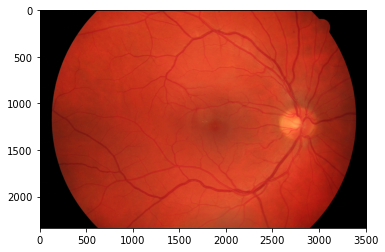

In [4]:
def read_image(filepath):
    '''
    Standardowa funkcja na wczytanie obrazu.
    :param filepath: - ścieżka do pliku
    :return img: - wczytany obraz
    '''
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)
    # OpenCV 2 wczytuje obrazy z odwróconymi kanałami kolorów, więc należy
    # przywrócić je do systemu RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

test_img = read_image(image_names[0])
plt.imshow(test_img)

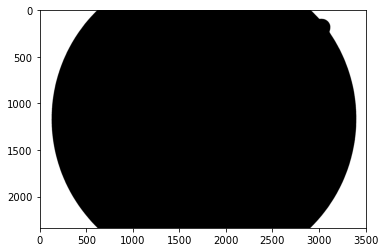

In [5]:
def get_mask(img, threshold = 5):
    '''
    Wyciąganie maski tła z obrazu za pomocą usuwania kolorów pikseli powyżej progu.
    :param img: - obraz wejściowy
    :param threshold: - próg powyżej którego kolory pikseli zostaną usunięte
    :return img_mask: - maska obrazu
    '''
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_mask = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for x, row in enumerate(img_mask):
        for y, _ in enumerate(row):
            # Zamiana obrazu na maskę binarną - poniżej progu na biało, powyżej na czarno
            img_mask[x][y] = 255 if img[x][y] < threshold else 0
    return img_mask

img_mask = get_mask(test_img)
plt.imshow(img_mask, cmap="gray")

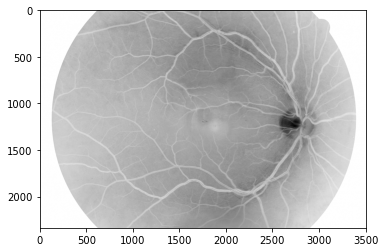

In [6]:
def get_green_channel(img):
    '''
    Ekstrakcja kanału zielonego (najlepszy kontrast żył do reszty obrazu).
    :param img: - obraz wejściowy
    :return green_img: - obraz składający się jedynie z zielonego kanału
    '''
    _, green_img, _ = cv2.split(img)
    green_img = invert_colors(green_img)
    return green_img

green_img = get_green_channel(test_img)
plt.imshow(green_img, cmap="gray")

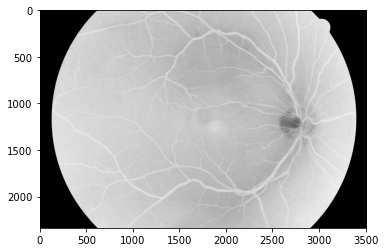

In [7]:
bck_img = remove_background(green_img, img_mask)
plt.imshow(bck_img, cmap="gray")

### Właściwe przetwarzanie obrazu

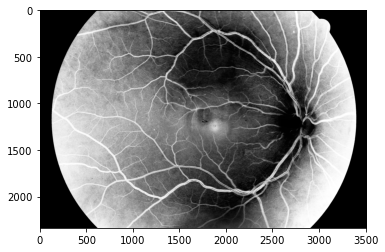

In [8]:
eq_img = cv2.equalizeHist(bck_img)
plt.imshow(eq_img, cmap="gray")

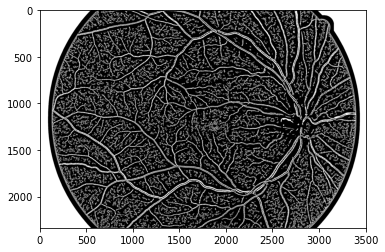

In [9]:
hes_img = hessian(eq_img)
plt.imshow(hes_img, cmap="gray")

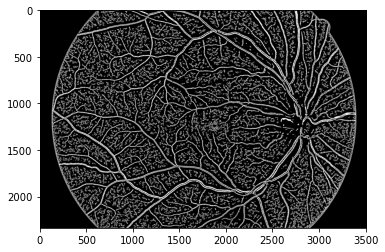

In [10]:
veins = remove_background(hes_img, img_mask)
plt.imshow(veins, cmap="gray")

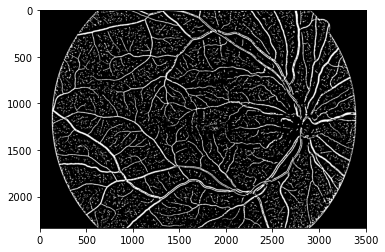

In [11]:
filtered_img = cv2.bilateralFilter(veins,11,75,75)
plt.imshow(filtered_img, cmap="gray")

### Końcowe przetwarzanie obrazu

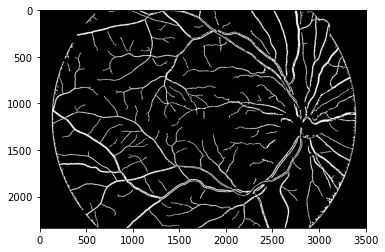

In [12]:
def remove_noise(img, min_size = 600):
    '''
    Usuwanie szumu z obrazu za pomocą.
    :param img: - obraz wejściowy
    :param min_size: - minimalny rozmiar obiektów, których nie należy usuwać
    :return clear_img: - obraz bez szumu
    '''
    # Detekcja połączonych obiektów w obrazie
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    # Ekstrakcja rozmiarów wykrytych komonentów
    sizes = stats[1:, -1]
    clear_img = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for i in range(0, nb_components - 1):
        # Jeżeli obiekt jest większy lub równy min_size, narysuj go na pustym
        # obrazie, w przeciwnym wypadku zignoruj
        if sizes[i] >= min_size:
            clear_img[output == i + 1] = 255
    return clear_img

clear_img = remove_noise(filtered_img)
plt.imshow(clear_img, cmap="gray")

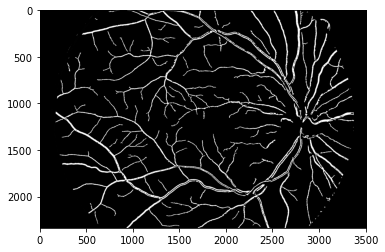

In [43]:
def remove_retina_circle(img, base_offset=2000):
    '''
    Usuwanie największego okręgu wokół oka za pomocą okręgów Hough.
    :param img: - obraz wejściowy
    :param base_offset: - od tego rozmiaru rozpoczęte zostaną poszukiwania
    :return no_retina_img: - obraz bez okręgu
    '''
    no_retina_img = img.copy()
    circle = np.zeros(img.shape, np.uint8)
    offset = 0
    detections = []
    while True:
        # Wykrywaj okręgi w obrazie zaczynając od rozmiaru base_offset (przyśpiesza obliczenia)
        detections = cv2.HoughCircles(no_retina_img, cv2.HOUGH_GRADIENT, 1.5, base_offset + offset)
        # Jeżeli nie można usunąć okręgu, przerwij algorytm
        if detections is None:
            return no_retina_img
        # Jeżeli wykryto największy okrąg, zakończ poszukiwania
        if len(detections[0]) == 1:
            break
        # Jeżeli przy danym rozmiarze jest więcej niż jedno koło, zwiększ minimalny rozmiar kół
        # i powtórz algorytm
        offset += 100
    for (x, y, r) in detections[0]:
        # Narysuj okrąg, który zostanie usunięty z obrazu
        cv2.circle(circle, (int(x), int(y)), int(r), (255, 255, 255), 40)
    # Usuń największy okrąg z obrazu
    no_retina_img = no_retina_img - circle
    return no_retina_img

plt.imshow(remove_retina_circle(clear_img, 2300), cmap="gray")

### Analiza statystyczna

In [85]:
def detect_veins(filepath):
    '''
    Algorytm scalający poprzednie funkcjonalności.
    :param filepath: - ścieżka do obrazu do przetworzenia
    '''
    print("Reading image...")
    # Wczytywanie obrazu
    img = read_image(filepath)
    print("Extracting mask...")
    img_mask = get_mask(img)
    print("Extracting green channel...")
    # Przetwarzanie wstępne
    img = get_green_channel(img)
    print("Removing background...")
    bck_img = remove_background(img, img_mask)
    print("Equalizing histograms...")
    eq_img = cv2.equalizeHist(bck_img)
    print("Extracting veins using hessian...")
    hes_img = hessian(eq_img)
    veins = remove_background(hes_img, img_mask)
    print("Using bilateral filter...")
    filtered_img = cv2.bilateralFilter(veins,11,75,75)
    print("Removing noise...")
    # Końcowe przetwarzanie obrazu
    clear_img = remove_noise(filtered_img)
    print("Removing retina's circle...")
    result = remove_retina_circle(clear_img)
    print("Image processing done.")
    return result

In [79]:
def get_data_for_analysis(filepath):
    mask_path = f"{filepath.split('.')[0]}.tif"
    veins = detect_veins(filepath)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return [np.concatenate(veins), np.concatenate(mask)]

### Macierz pomyłek

Reading image...
Extracting mask...
Extracting green channel...
Removing background...
Equalizing histograms...
Extracting veins using hessian...
Using bilateral filter...
Removing noise...
Removing retina's circle
Creating confusion matrix...


  0%|          | 0/8185344 [00:00<?, ?it/s]

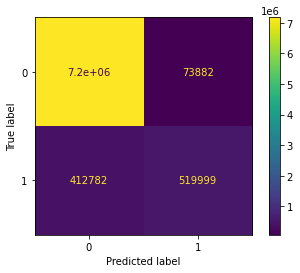

In [87]:
def get_confusion_matrix(data):
    predictions, truth = data
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0
    print("Creating confusion matrix...")
    for idx, val in enumerate(tqdm(predictions)):
        if val == truth[idx]:
            if val == 255:
                true_positives += 1
            else:
                true_negatives += 1
        else:
            if val == 255:
                false_positives += 1
            else:
                false_negatives += 1

    confusion_matrix = np.matrix([
        [true_negatives, false_positives],
        [false_negatives, true_positives]
    ])
    return confusion_matrix

data = get_data_for_analysis(image_names[4])
confusion_matrix = get_confusion_matrix(data)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
plt.show()

### Podstawowe miary

In [98]:
def get_analysis_metrics(TP, TN, FP, FN):
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    # Sensitivity = TP / (TP + FN)
    sensitivity = TP / (TP + FN)
    # Specificity = TN / (TN + FP)
    specificity = TN / (TN + FP)
    # Balanced Accuracy = (Sensitivity + Specificity) / 2
    balanced_accuracy = (sensitivity + specificity) / 2
    # Geometric Accuracy = Sqrt(Sensitivity * Specificity)
    geometric_accuracy = math.sqrt(sensitivity * specificity)
    
    return [accuracy, sensitivity, specificity, balanced_accuracy, geometric_accuracy]

Reading image...
Extracting mask...
Extracting green channel...
Removing background...
Equalizing histograms...
Extracting veins using hessian...
Using bilateral filter...
Removing noise...
Removing retina's circle
Creating confusion matrix...


  0%|          | 0/8185344 [00:00<?, ?it/s]

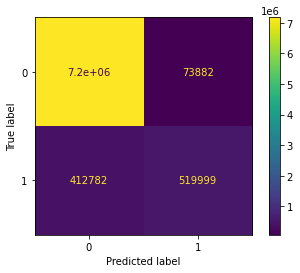

Trafność: 93%
Czułość: 53%
Swoistość: 98%
Zrównoważona trafność (średnia arytmetyczna): 75%
Zrównoważona trafność (średnia geometryczna): 72%


In [100]:
def print_analysis(filepath):
    '''
    Funkcja wyświetlająca statystyki dla obrazu. Scala wszystko w jedno.
    '''
    data = get_data_for_analysis(filepath)
    mat = get_confusion_matrix(data)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    disp.plot()
    plt.show()
    metrics = get_analysis_metrics(mat[1, 1], mat[0, 0], mat[0, 1], mat[1, 0])
    print(f"Trafność: {int(metrics[0] * 100)}%")
    print(f"Czułość: {int(metrics[1] * 100)}%")
    print(f"Swoistość: {int(metrics[2] * 100)}%")
    print(f"Zrównoważona trafność (średnia arytmetyczna): {int(metrics[3] * 100)}%")
    print(f"Zrównoważona trafność (średnia geometryczna): {int(metrics[4] * 100)}%")

print_analysis(image_names[0])

Reading image...
Extracting mask...
Extracting green channel...
Removing background...
Equalizing histograms...
Extracting veins using hessian...
Using bilateral filter...
Removing noise...
Removing retina's circle
Creating confusion matrix...


  0%|          | 0/8185344 [00:00<?, ?it/s]

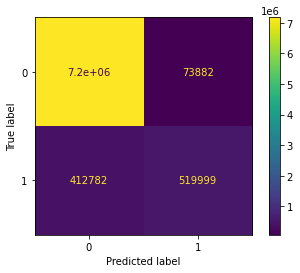

Trafność: 96%
Czułość: 62%
Swoistość: 99%
Zrównoważona trafność (średnia arytmetyczna): 81%
Zrównoważona trafność (średnia geometryczna): 79%


In [101]:
print_analysis(image_names[1])

Reading image...
Extracting mask...
Extracting green channel...
Removing background...
Equalizing histograms...
Extracting veins using hessian...
Using bilateral filter...
Removing noise...
Removing retina's circle
Creating confusion matrix...


  0%|          | 0/8185344 [00:00<?, ?it/s]

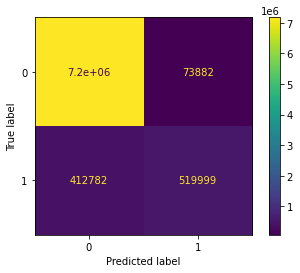

Trafność: 93%
Czułość: 53%
Swoistość: 98%
Zrównoważona trafność (średnia arytmetyczna): 76%
Zrównoważona trafność (średnia geometryczna): 72%


In [102]:
print_analysis(image_names[2])

Reading image...
Extracting mask...
Extracting green channel...
Removing background...
Equalizing histograms...
Extracting veins using hessian...
Using bilateral filter...
Removing noise...
Removing retina's circle
Creating confusion matrix...


  0%|          | 0/8185344 [00:00<?, ?it/s]

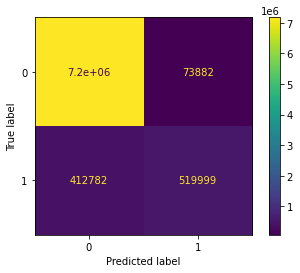

Trafność: 95%
Czułość: 58%
Swoistość: 99%
Zrównoważona trafność (średnia arytmetyczna): 79%
Zrównoważona trafność (średnia geometryczna): 76%


In [103]:
print_analysis(image_names[3])

Reading image...
Extracting mask...
Extracting green channel...
Removing background...
Equalizing histograms...
Extracting veins using hessian...
Using bilateral filter...
Removing noise...
Removing retina's circle
Creating confusion matrix...


  0%|          | 0/8185344 [00:00<?, ?it/s]

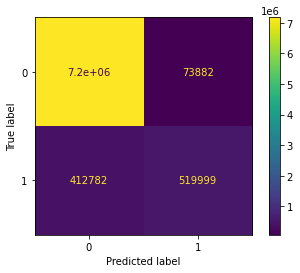

Trafność: 94%
Czułość: 55%
Swoistość: 98%
Zrównoważona trafność (średnia arytmetyczna): 77%
Zrównoważona trafność (średnia geometryczna): 74%


In [104]:
print_analysis(image_names[4])